In [75]:
import torch
from torch import nn 
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [77]:
device

'cpu'

In [78]:
transfomrs = transforms.Compose([
    transforms.ToTensor()
])

In [79]:
def to_one_hot(y, num_classes=10):
    return torch.eye(num_classes)[labels]

In [80]:
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transfomrs)


In [81]:
train_data, val_data, test_data = random_split(dataset, [0.8, 0.1, 0.1])

In [82]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
val_dl = DataLoader(train_data, batch_size=64, shuffle=False)

In [83]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Text(0.5, 1.0, '0')

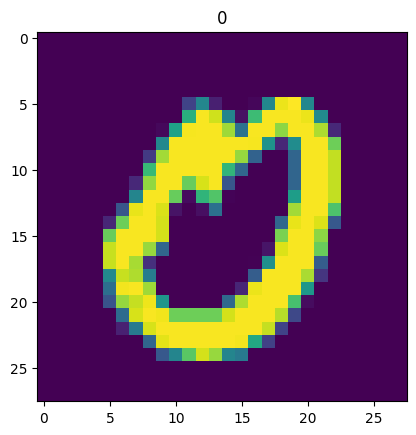

In [84]:
x, y = train_data[0]
x = x.permute(1, 2, 0)
plt.imshow(x)
plt.title(y)

In [85]:
def output(dataset, limit):
    for i, (x, y) in enumerate(dataset):
        x = x.permute(1, 2, 0)
        plt.imshow(x)
        plt.title(y)
        plt.show()

        if i >= limit:
            break
        


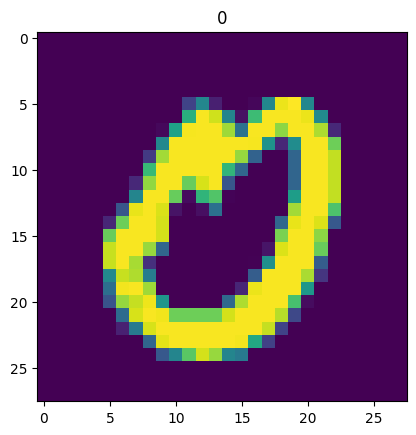

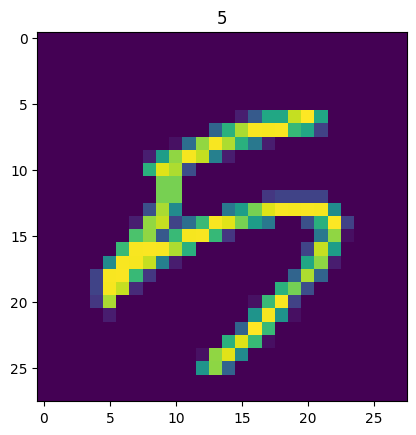

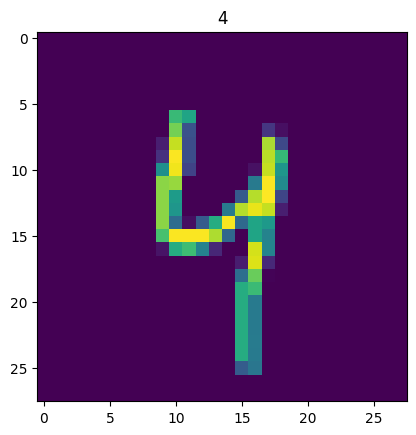

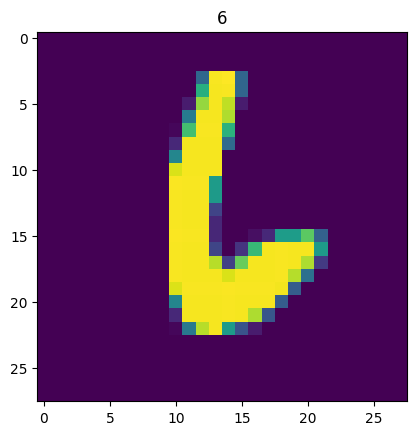

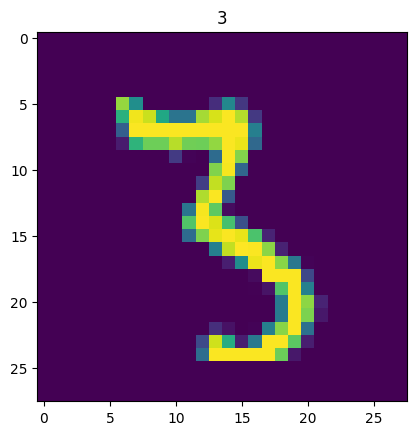

In [86]:
output(train_data, 4)

In [87]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(784 + 10, 400)

        self.mu_linear = nn.Linear(400, 20)
        self.std_linear = nn.Linear(400, 20)

    def forward(self, x, y):
        x = x.view(x.size(0), -1)

        # if we pass a tensor like torch.tensor([3]) (where 3 - is a class, we'd like to generate), then we turn scalar [3] into one-hot vector of
        # 10 classes (as it is demonstrated in num_classes=10) which will have form:
        # [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
        if y.dim() == 1:
            y = F.one_hot(y, num_classes=10).float()

            
        xy = torch.cat([x, y], dim=1)

        h = F.relu(self.linear1(xy))
        
        mu = self.mu_linear(h)
        logvar = self.std_linear(h)
        return mu, logvar

In [88]:
tensor1 = torch.rand(1, 28, 28).to(device)
tensor2 = torch.rand(1, 10).to(device)

encoder = Encoder()
encoder.to(device)

mu, logvar = encoder(tensor1, tensor2)
print(mu.shape, logvar.shape)

torch.Size([1, 20]) torch.Size([1, 20])


In [89]:
tensor1 = torch.rand(1, 28, 28).to(device)
tensor2 = torch.tensor([3]).to(device)

encoder = Encoder()
encoder.to(device)

mu, logvar = encoder(tensor1, tensor2)
print(mu.shape, logvar.shape)

torch.Size([1, 20]) torch.Size([1, 20])


In [90]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(20+10, 400)
        self.linear2 = nn.Linear(400, 784)
        self.unflatten = nn.Unflatten(1, (1, 28, 28))

    def forward(self, z, y):
        if y.dim() == 1:
            y = F.one_hot(y, num_classes=10).float()

        # print(f"x.shape: {x.shape}, y.shape: {y.shape}")
        
        zy = torch.cat([z, y], dim=1)
        h = F.relu(self.linear1(zy))
        out = F.sigmoid(self.linear2(h))
        out = self.unflatten(out)
        return out
        
    def predict(self, z, y):
        self.eval()

        with torch.no_grad():
            out = self.forward(z, y)
        out = out.squeeze(0).permute(1, 2, 0).cpu().numpy()
        return out 

In [91]:
tensor1 = torch.rand(1, 20).to(device)
tensor2 = torch.rand(1, 10).to(device)

decoder = Decoder()
decoder.to(device)

out = decoder.predict(tensor1, tensor2)
print(out.shape)

out = decoder(tensor1, tensor2)
print(out.shape)

(28, 28, 1)
torch.Size([1, 1, 28, 28])


In [92]:
tensor1 = torch.rand(1, 20).to(device)
# we're "asking" model to generate object of specific class - 3, so it should be a digit "3".
tensor2 = torch.tensor([3]).to(device)

decoder = Decoder()
decoder.to(device)

out = decoder.predict(tensor1, tensor2)
print(out.shape)

out = decoder(tensor1, tensor2)
print(out.shape)

(28, 28, 1)
torch.Size([1, 1, 28, 28])


In [93]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparametrize(mu, logvar)
        out = self.decoder(z, y)
        return out, mu, logvar

    def predict(self, x, y):
        self.eval()

        with torch.no_grad():
            out, _, _ = self.forward(x, y)

        out = out.squeeze(0).permute(1, 2, 0).cpu().numpy()
        return out 

In [94]:
tensor1 = torch.rand(1, 28, 28).to(device)
tensor2 = torch.tensor([3]).to(device)

model = VAE()
model.to(device)

out = model.predict(tensor1, tensor2)
print(out.shape)

out = model(tensor1, tensor2)
print(out[0].shape)

(28, 28, 1)
torch.Size([1, 1, 28, 28])


In [95]:
model = VAE()
model.to(device)

VAE(
  (encoder): Encoder(
    (linear1): Linear(in_features=794, out_features=400, bias=True)
    (mu_linear): Linear(in_features=400, out_features=20, bias=True)
    (std_linear): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=30, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=784, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

Text(0.5, 1.0, 'Generated')

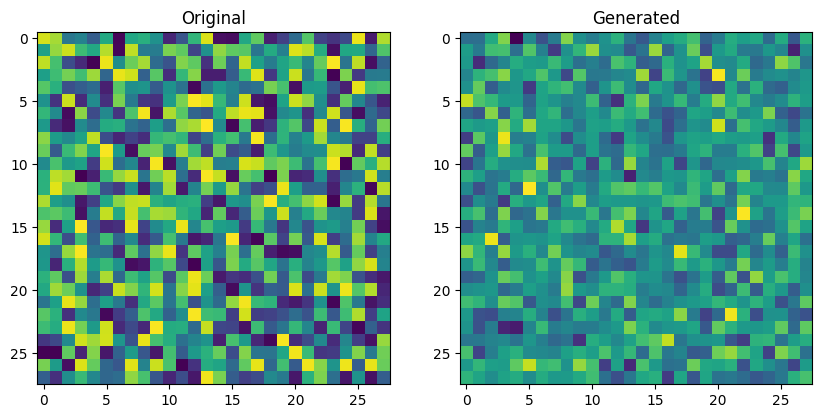

In [96]:
x_tensor = torch.rand(1, 28, 28).to(device)
x_t_tensor = x_tensor.permute(1, 2, 0).cpu().numpy()

y_tensor = torch.rand(1, 10).to(device)
res = model.predict(x_tensor, y_tensor)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_t_tensor)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.title("Generated")

Text(0.5, 1.0, 'Generated')

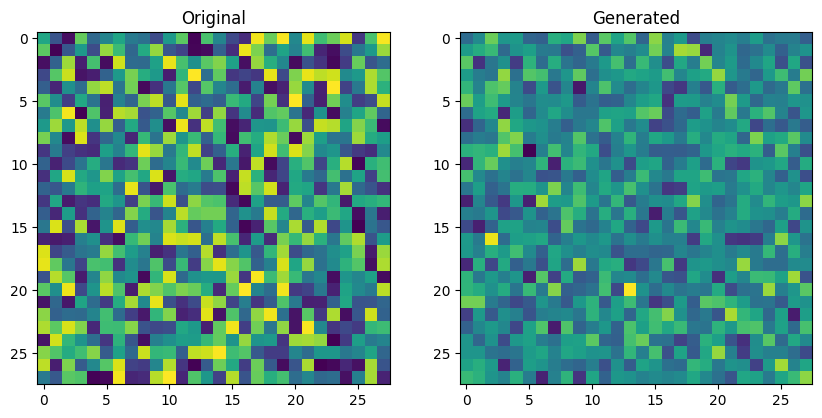

In [97]:
x_tensor = torch.rand(1, 28, 28).to(device)
x_t_tensor = x_tensor.permute(1, 2, 0).cpu().numpy()

y_tensor = torch.tensor([2]).to(device)
res = model.predict(x_tensor, y_tensor)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_t_tensor)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(res)
plt.title("Generated")

In [98]:
def loss_function(recon_x, x, mu, logvar, kl_weight=0.1):
    # recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # or BCE, if normilized in range [0,1]
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL-divergention
    return recon_loss + kl_loss * kl_weight

optimizer = Adam(model.parameters(), lr=1e-3)

In [99]:
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
    
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            # print(y.shape)

            optimizer.zero_grad()

            out, mu, logvar = model(x, y)
            loss = loss_fn(out, x, mu, logvar)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        total_train_loss = train_loss / len(train_dl)


        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)
                # print(y.shape)

                out, mu, logvar = model(x, y)
                loss = loss_fn(out, x, mu, logvar)
                val_loss += loss.item()

        total_val_loss = val_loss / len(val_dl)
        
        history["train_loss"].append(total_train_loss)
        history["val_loss"].append(total_val_loss)

        print(
            f"Epoch: {epoch+1}; "
            f"train_loss: {total_train_loss:.4f}; "
            f"val_loss: {total_val_loss:.4f}"
        )

    return history 

In [100]:
history = train(model, train_dl, val_dl, optimizer, loss_function, 50, device)

100%|██████████| 750/750 [00:06<00:00, 108.09it/s]


Epoch: 1; train_loss: 1808.1355; val_loss: 1109.3980


100%|██████████| 750/750 [00:07<00:00, 104.88it/s]


Epoch: 2; train_loss: 997.8392; val_loss: 923.7267


100%|██████████| 750/750 [00:07<00:00, 105.49it/s]


Epoch: 3; train_loss: 881.7740; val_loss: 842.1651


100%|██████████| 750/750 [00:07<00:00, 101.14it/s]


Epoch: 4; train_loss: 827.0133; val_loss: 802.7884


100%|██████████| 750/750 [00:06<00:00, 108.08it/s]


Epoch: 5; train_loss: 792.9840; val_loss: 773.3189


100%|██████████| 750/750 [00:06<00:00, 109.95it/s]


Epoch: 6; train_loss: 769.3226; val_loss: 752.6666


100%|██████████| 750/750 [00:06<00:00, 111.14it/s]


Epoch: 7; train_loss: 751.5714; val_loss: 734.9869


100%|██████████| 750/750 [00:06<00:00, 111.64it/s]


Epoch: 8; train_loss: 738.1897; val_loss: 724.7157


100%|██████████| 750/750 [00:07<00:00, 104.64it/s]


Epoch: 9; train_loss: 726.7579; val_loss: 716.1480


100%|██████████| 750/750 [00:06<00:00, 108.41it/s]


Epoch: 10; train_loss: 717.9533; val_loss: 707.9646


100%|██████████| 750/750 [00:06<00:00, 109.11it/s]


Epoch: 11; train_loss: 709.6709; val_loss: 696.7471


100%|██████████| 750/750 [00:07<00:00, 107.12it/s]


Epoch: 12; train_loss: 703.1619; val_loss: 690.8019


100%|██████████| 750/750 [00:07<00:00, 103.18it/s]


Epoch: 13; train_loss: 697.3722; val_loss: 692.1673


100%|██████████| 750/750 [00:07<00:00, 106.51it/s]


Epoch: 14; train_loss: 692.0527; val_loss: 682.8408


100%|██████████| 750/750 [00:06<00:00, 110.23it/s]


Epoch: 15; train_loss: 687.2187; val_loss: 677.8093


100%|██████████| 750/750 [00:06<00:00, 108.49it/s]


Epoch: 16; train_loss: 681.9101; val_loss: 673.1128


100%|██████████| 750/750 [00:06<00:00, 110.50it/s]


Epoch: 17; train_loss: 678.7884; val_loss: 670.5803


100%|██████████| 750/750 [00:06<00:00, 111.91it/s]


Epoch: 18; train_loss: 674.7961; val_loss: 668.0653


100%|██████████| 750/750 [00:07<00:00, 102.14it/s]


Epoch: 19; train_loss: 671.8929; val_loss: 665.4568


100%|██████████| 750/750 [00:07<00:00, 106.63it/s]


Epoch: 20; train_loss: 668.6500; val_loss: 662.2142


100%|██████████| 750/750 [00:06<00:00, 110.39it/s]


Epoch: 21; train_loss: 665.7114; val_loss: 658.8430


100%|██████████| 750/750 [00:06<00:00, 107.45it/s]


Epoch: 22; train_loss: 663.5935; val_loss: 654.9636


100%|██████████| 750/750 [00:07<00:00, 104.02it/s]


Epoch: 23; train_loss: 660.6741; val_loss: 652.0095


100%|██████████| 750/750 [00:07<00:00, 104.13it/s]


Epoch: 24; train_loss: 658.0413; val_loss: 650.7024


100%|██████████| 750/750 [00:06<00:00, 108.87it/s]


Epoch: 25; train_loss: 656.1834; val_loss: 650.6235


100%|██████████| 750/750 [00:06<00:00, 107.52it/s]


Epoch: 26; train_loss: 653.7039; val_loss: 646.5815


100%|██████████| 750/750 [00:06<00:00, 110.07it/s]


Epoch: 27; train_loss: 651.8086; val_loss: 644.1337


100%|██████████| 750/750 [00:06<00:00, 109.46it/s]


Epoch: 28; train_loss: 649.5435; val_loss: 641.6518


100%|██████████| 750/750 [00:07<00:00, 104.22it/s]


Epoch: 29; train_loss: 648.6435; val_loss: 640.3427


100%|██████████| 750/750 [00:06<00:00, 110.31it/s]


Epoch: 30; train_loss: 646.6453; val_loss: 639.3861


100%|██████████| 750/750 [00:06<00:00, 107.64it/s]


Epoch: 31; train_loss: 644.7706; val_loss: 636.0443


100%|██████████| 750/750 [00:06<00:00, 111.25it/s]


Epoch: 32; train_loss: 643.2619; val_loss: 636.1157


100%|██████████| 750/750 [00:06<00:00, 111.24it/s]


Epoch: 33; train_loss: 641.5785; val_loss: 635.9255


100%|██████████| 750/750 [00:06<00:00, 107.79it/s]


Epoch: 34; train_loss: 640.1739; val_loss: 631.5586


100%|██████████| 750/750 [00:06<00:00, 108.54it/s]


Epoch: 35; train_loss: 638.8255; val_loss: 631.1737


100%|██████████| 750/750 [00:06<00:00, 110.66it/s]


Epoch: 36; train_loss: 637.5208; val_loss: 630.7135


100%|██████████| 750/750 [00:07<00:00, 107.03it/s]


Epoch: 37; train_loss: 636.2423; val_loss: 629.5237


100%|██████████| 750/750 [00:06<00:00, 109.31it/s]


Epoch: 38; train_loss: 635.1423; val_loss: 627.5008


100%|██████████| 750/750 [00:06<00:00, 107.32it/s]


Epoch: 39; train_loss: 633.9707; val_loss: 628.4208


100%|██████████| 750/750 [00:06<00:00, 109.31it/s]


Epoch: 40; train_loss: 633.0763; val_loss: 624.4634


100%|██████████| 750/750 [00:06<00:00, 109.08it/s]


Epoch: 41; train_loss: 632.2081; val_loss: 624.6425


100%|██████████| 750/750 [00:07<00:00, 106.70it/s]


Epoch: 42; train_loss: 630.3215; val_loss: 623.1796


100%|██████████| 750/750 [00:06<00:00, 110.52it/s]


Epoch: 43; train_loss: 629.7964; val_loss: 623.7275


100%|██████████| 750/750 [00:06<00:00, 109.65it/s]


Epoch: 44; train_loss: 628.8438; val_loss: 622.3016


100%|██████████| 750/750 [00:06<00:00, 107.74it/s]


Epoch: 45; train_loss: 627.9306; val_loss: 619.2666


100%|██████████| 750/750 [00:06<00:00, 109.76it/s]


Epoch: 46; train_loss: 627.0843; val_loss: 619.9923


100%|██████████| 750/750 [00:06<00:00, 111.57it/s]


Epoch: 47; train_loss: 625.6832; val_loss: 619.0982


100%|██████████| 750/750 [00:06<00:00, 111.52it/s]


Epoch: 48; train_loss: 625.5424; val_loss: 618.6887


100%|██████████| 750/750 [00:06<00:00, 109.93it/s]


Epoch: 49; train_loss: 624.3682; val_loss: 619.1175


100%|██████████| 750/750 [00:06<00:00, 108.87it/s]

Epoch: 50; train_loss: 623.8774; val_loss: 616.5549


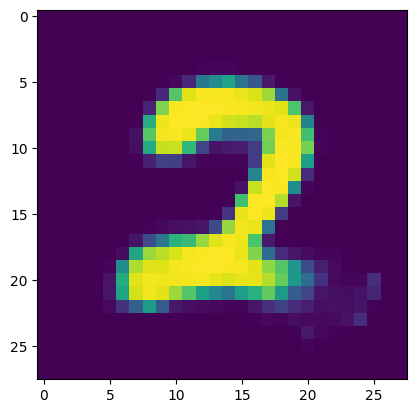

In [103]:
# сreate one-hot vector 

# choose a number to generate
digit = 2

# create zero-vector of size of ten
y_tensor = torch.zeros(1, 10).to(device)

# put a number to generate into it's place into one-hot vector
y_tensor[0, digit] = 1.0

# choose a random  noise
z_tensor = torch.randn(1, 20).to(device)

# generate & display image 
generated = model.decoder.predict(z_tensor, y_tensor)
plt.imshow(generated)

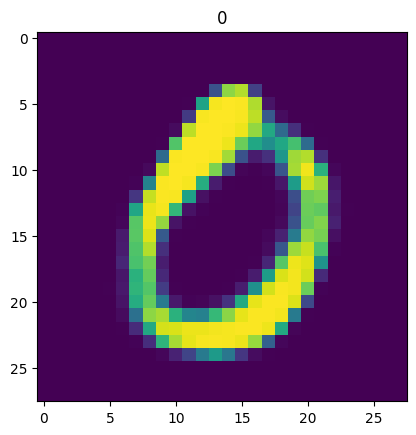

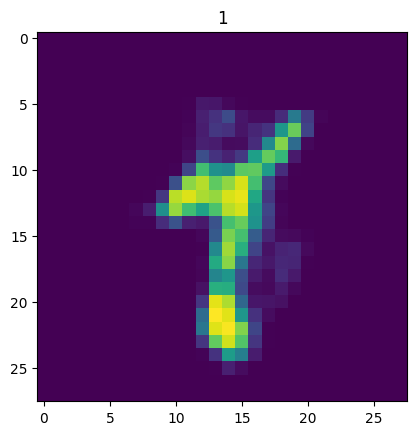

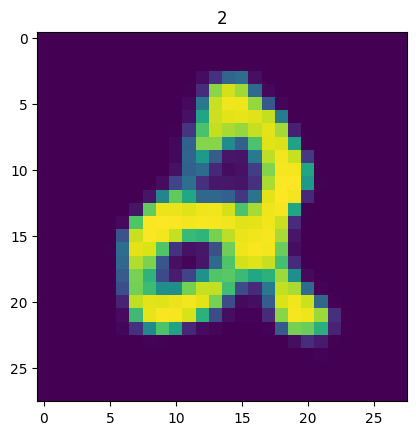

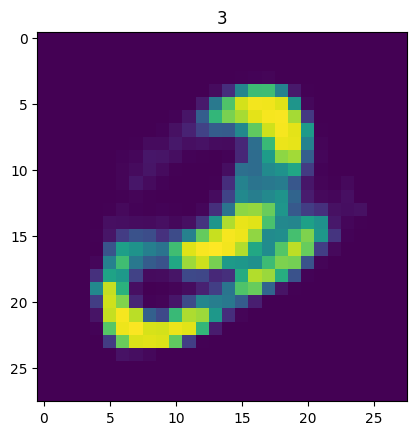

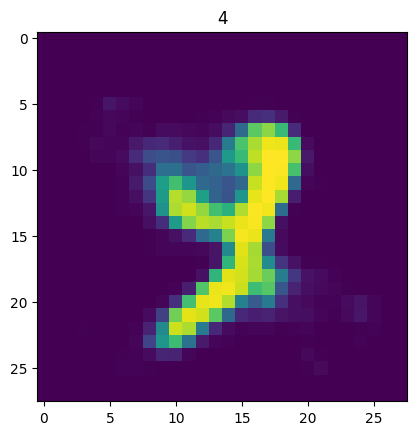

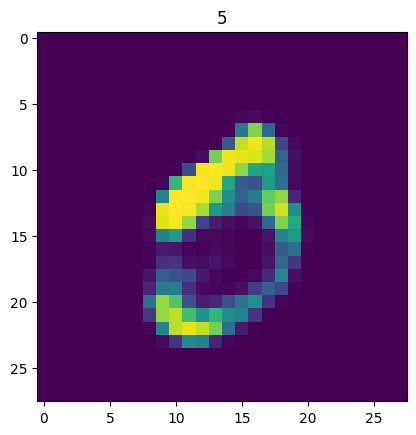

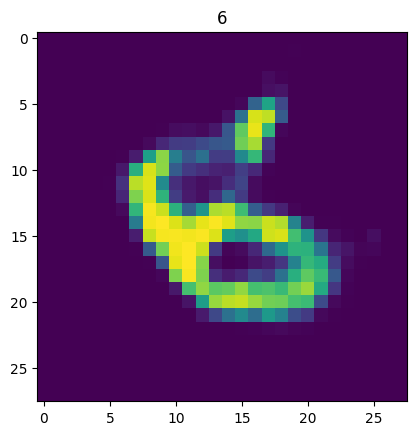

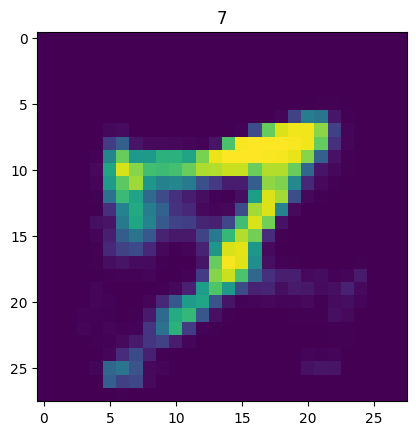

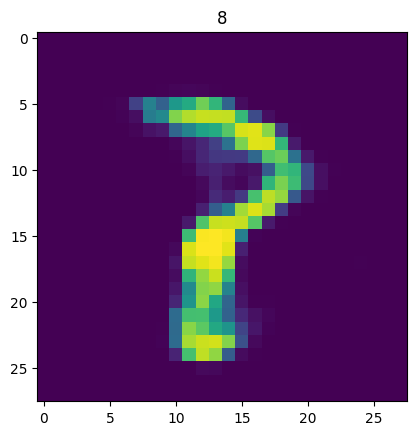

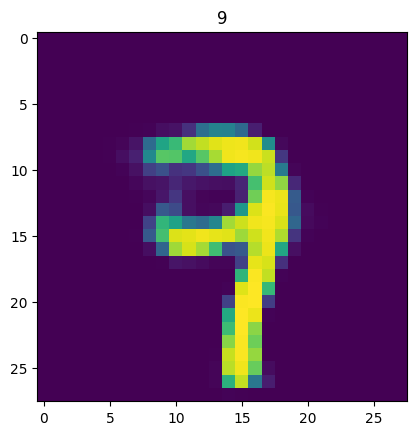

In [107]:
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for number in numbers:
    digit = number

    z_tensor = torch.randn(1, 20).to(device)
    y_tensor = torch.zeros(1, 10).to(device)
    y_tensor[0, digit] = 1.0

    generated = model.decoder.predict(z_tensor, y_tensor)
    plt.imshow(generated)
    plt.title(number)
    plt.show()